## Periodic Array

Calculate output field for a plane wave of wave number k and
amplitude A0 passing through  
1) aperture plate: rectangular grid of spots of radius a, dx,dy center to center; spots can be transmissive or reflective  
2) lens f1  
3) circular aperture radius b  
4) lens f2  

In [47]:
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.integrate import quad, dblquad
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time, perf_counter_ns

TODO: 
1) make field input aperture periodic, 1D  
2) plot axial field from lens f2 onward using eq i derived

In [48]:
## functions

def from_quadrant3(qd3, field=None):
    """
    construct field with rectangular symmetry given only
    quadrant 3 (i.e., field is mirrored across x axis and
    across y axis)
    
    'qd3' 2D numpy array
    Return 'field' 2D numpy array
    """
    
    xpts, ypts = qd3.shape
    xmpt, ympt = int(xpts/2), int(ypts/2)
    
    if field is None:
        field = zeros((2*xpts, 2*ypts), complex)
    
    field[:midpt, :midpt] = qd3
    # qd4
    field[:midpt, midpt:] = flip(qd3, axis=1) 
    # qd1
    field[midpt:, midpt:] = flip(qd3)
    # qd2
    field[midpt:, :midpt] = flip(qd3, axis=0)
    
    return field

def get_meshgrid(w, pts, polar=False):
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if polar:
        rr = sqrt(xx**2 + yy**2)
        phi = arctan2(yy,xx)
        phi[:midpt, :] += 2*pi
        return x,midpt,rr,phi
    else:
        return x,midpt,xx,yy
    
def get_grid(dx,dy,xnum,ynum):
    xpts = []
    ypts = []
    for i in range(xnum):
        for j in range(ynum):
            xpts.append((1+i)*dy - dy*(1+ynum)/2)
            ypts.append((1+j)*dx - dx*(1+xnum)/2)
    return xpts, ypts

def figax():
    fig,ax = plt.subplots()
    ax.set_aspect('equal')
    return fig, ax

In [4]:
## physics and system params
k = 2*pi/1.064e-6
A0 = 1
# want M = f2/f1 something like ~ .03
f1 = 1
f2 = 0.03
a = 1e-4 # aperture 1 radius = 100 um
b = f1*3.8317/(a*k) # the filter radius. 3.8317 is a00, the first zero of the J0(x).

dx = 3*a # center-to-center spacing between spots
dy = dx

(-0.0006000000000000001, 0.0006000000000000001)

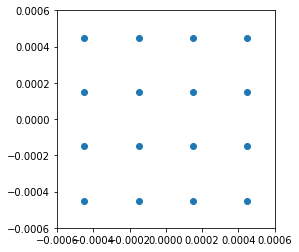

In [5]:
xspots = 4
yspots = 4
xpts, ypts = get_grid(dx,dy,xspots,yspots)

# lines = []
# for i in range(yspots):
#     for j in range(xspots):
#         lines.append([[0, (j+1)*dx - (dx + xspots)/2], [0, (i+1)*dy - (dy + yspots)/2]])
        
fig,ax = plt.subplots()
ax.scatter(xpts, ypts)

# for line in lines:
#     ax.plot(*line)
ax.set_aspect('equal')
ax.set_xlim(-xspots*dx/2, xspots*dx/2)
ax.set_ylim(-yspots*dx/2, yspots*dy/2)

In [6]:
## build the aperture mask:

w = xspots*dx/2 # array half-width 
pts = 200 # the grid will be pts x pts
xarr,midpt,xx,yy = get_meshgrid(w, pts) 

# the centroids of the apertures
xpts, ypts = get_grid(dx,dy,4,4)

 
plate = 0 # block the field
aperture = 1 # transmit the field
dimx = dimy = pts
midx = int(dimx/2)
midy = int(dimy/2)

mask_a = full((dimx, dimy), plate)

qd3 = mask_a[0:midx, 0:midy]

for i in range(midy):
    for j in range(midx):
        
        # check if coordinate overlaps an aperture
        for x in xpts:
            for y in ypts:
                if sqrt((xx[0,j]-x)**2 + (yy[i,0]-y)**2) < a:
                    qd3[i,j] = aperture
                
mask_a = from_quadrant3(qd3, mask_a)
print("input mask generated")

input mask generated


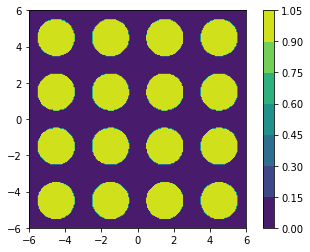

In [7]:
fig,ax = plt.subplots()
cbar = ax.contourf(xarr/a,xarr/a,mask_a)
ax.set_aspect('equal')
fig.colorbar(cbar)

## Analytically derived fields 

In [83]:
w = 200*a
pts = 200
xarr,midpt,rr,phi = get_meshgrid(w, pts, polar=True)

field1 = zeros((pts,pts), complex)

dx = dy = 3*a
xnum = ynum = 8
xcents, ycents = get_grid(dx,dy,xnum,ynum)

# def periodic_phase(i, j, z): 
#     xj = j*dx
#     yi = i*dy
#     total = 0 + 0j
#     for x in xcents:
#         for y in ycents:
#             # todo: this phase is wrong. should be exp(1j k x r1/z)exp(1j k y r1/z) or similar
# #             total += exp(1j*sqrt(x**2 + y**2)*r1*k/z)
#             total += exp(1j*x*xj*k/f1)*exp(1j*y*yi*k/f1)
#     return total

def repeat_phase(i,j):
    # this works for a square grid; need a dedicated yarr otherwise
    x1 = xarr[i] 
    y1 = xarr[j]
    return (sin(xnum*k*dx*x1/(2*f1))*sin(ynum*k*dy*y1/(2*f1)) \
            /(sin(sin(k*dx*x1/(2*f1))*sin(k*dy*y1/(2*f1)))))

t0 = time()
q3_phases = empty((midpt, midpt), complex)
q3 = copy(field1[:midpt,:midpt])
for i in range(midpt):
    for j in range(midpt):
        q3_phases[i,j] = repeat_phase(i,j)
        q3[i,j] = A0*a*j1(a*rr[i,j]*k/f1)*q3_phases[i,j]/rr[i,j]
        
field1 = from_quadrant3(q3, field=field1)
print(f"calculated field1 in {time()-t0} s")

calculated field1 in 0.1795508861541748 s


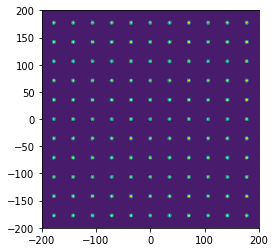

In [84]:
phases = from_quadrant3(q3_phases)
fig,ax = figax()
cbar = ax.contourf(xarr/a, xarr/a, phases**2)

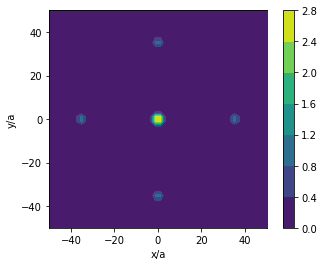

In [90]:
fig,ax = figax()
I1 = conjugate(field1)*field1
cbar = ax.contourf(xarr/a, xarr/a, I1)
roi = 50
ax.set_xlim(-roi,roi)
ax.set_ylim(-roi,roi)
ax.set_xlabel('x/a')
ax.set_ylabel('y/a')
fig.colorbar(cbar)

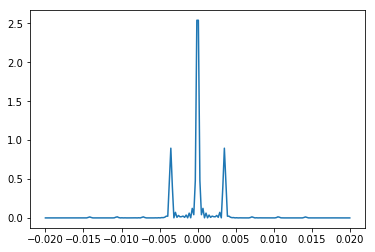

In [91]:
plt.plot(xarr, (conjugate(field1)*field1)[midpt,:])